# With Dcross=3e-12, and others with Andrew's value, change neg porosity to mimic degradation

In [20]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;
from scipy.io import savemat,loadmat;from pybamm import constants,exp,tanh,sqrt;import matplotlib as mpl; fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import traceback
import imageio.v2 as imageio
font = {'family' : 'DejaVu Sans',
        'size'   : fs}
mpl.rc('font', **font)

In [21]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import (
    PlotDynamics,
    Plot_Loc_Var,
    Plot_Loc_Var_sol,
    Plot_Single_Static,
)

In [22]:
V_max = 4.2;        V_min = 2.5;
total_cycle = 500; save_at_cycles= 1
Experiment_short   = pybamm.Experiment( [ (
    f"Discharge at 1 C until {V_min} V", 
    f"Charge at 1 C until {V_max} V", 
    f"Hold at {V_max} V until C/5")    ] * 1 ) 
Experiment_s   = pybamm.Experiment( [ (
    f"Discharge at 1 C for 240 s", )    ] * 1 )   

In [23]:
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R7/'; 
Target  = 'a2_1_scan_neg_por/'
if not os.path.exists(BasicPath + Target):
    os.mkdir(BasicPath + Target);

In [24]:
model = pybamm.lithium_ion.DFN(     
    options={  
        "solvent diffusion": "EC wo refill"     } )
NegPor_all = [0.25, 0.1, 0.05]


using EC wo refill for Li+


Para_0.search('mole')

In [25]:

ChemistryChen=pybamm.parameter_sets.Chen2020 
ChemistryChen["electrolyte"] = "lipf6_Nyman2008Exp";
Para_0=pybamm.ParameterValues(chemistry=ChemistryChen);
Para_0['EC transference number'] =     -1.4
Para_0['Cation transference number'] =     0.28
Para_0['EC Lithium ion cross diffusivity [m2.s-1]'] = 3e-12
Para_0['Typical EC Lithium ion cross diffusivity [m2.s-1]'] =  3e-12
Para_0['EC diffusivity in electrolyte [m2.s-1]'] =  5e-10

Para_0['Electrolyte diffusivity [m2.s-1]'] =  3e-10
#print(Model_d.options["solvent diffusion"])
Para_0['Ratio of lithium moles to SEI moles'] =  1

c_e = model.variables["Electrolyte concentration [mol.m-3]"]
T = model.variables["Cell temperature [K]"]
c_EC = model.variables["EC concentration [mol.m-3]"]
model.variables["c(EC) over c(Li+)"] = c_EC / c_e
model.variables["Electrolyte conductivity [S.m-1]"] =(
    Para_0['Electrolyte conductivity [S.m-1]'](c_e,c_EC, T))
    #model.variables["Electrolyte diffusivity [m2.s-1]"] =(
    #    Para_0['Electrolyte diffusivity [m2.s-1]'](c_e,c_EC, T))

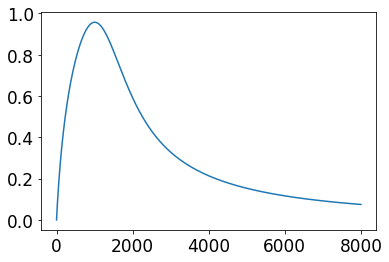

<AxesSubplot:>

In [26]:
c_e_plt = pybamm.linspace(0, 8e3, 1000)
sigma_plt = Para_0['Electrolyte conductivity [S.m-1]']
diff_plt  = Para_0['Electrolyte diffusivity [m2.s-1]']
pybamm.plot(c_e_plt, sigma_plt(c_e_plt,4540, 298.15))

Xi =  list(np.linspace(-1.8, -1.0, 10))
print(type(Xi))

In [27]:
Sim = [];Sol=[]; 
for NegPor in NegPor_all:
    Para_0['Negative electrode porosity'] = NegPor

    sim = pybamm.Simulation(
        model, experiment = Experiment_short,
        parameter_values = Para_0,
        solver = pybamm.CasadiSolver(),)  
    try:
        sol = sim.solve(save_at_cycles=save_at_cycles,);
    except:
        print('Fail for NegPor= ',NegPor)
    else:
        Sol.append(sol)   
        print('Succeed for NegPor= ',NegPor)

Succeed for NegPor=  0.25
Succeed for NegPor=  0.1
Succeed for NegPor=  0.05


print(Sol_ddiff["Electrolyte conductivity [S.m-1]"].entries[:,51] )
print(Sol_ddiff["Electrolyte diffusivity [m2.s-1]"].entries[:,-1])

In [28]:
model.variables.search("electrode")

Electrode current density
Electrode transport efficiency
Gradient of negative electrode potential
Gradient of positive electrode potential
Leading-order negative electrode porosity
Leading-order positive electrode porosity
Leading-order x-averaged negative electrode porosity
Leading-order x-averaged negative electrode porosity change
Leading-order x-averaged positive electrode porosity
Leading-order x-averaged positive electrode porosity change
Loss of active material in negative electrode [%]
Loss of active material in positive electrode [%]
Negative electrode SEI interfacial current density
Negative electrode SEI interfacial current density [A.m-2]
Negative electrode SEI on cracks interfacial current density
Negative electrode SEI on cracks interfacial current density [A.m-2]
Negative electrode SEI on cracks volumetric interfacial current density
Negative electrode SEI on cracks volumetric interfacial current density [A.m-3]
Negative electrode SEI volumetric interfacial current densi

In [29]:
print(Sol[0]["Electrolyte conductivity [S.m-1]"].entries[-1,-1])
print(Sol[1]["Electrolyte conductivity [S.m-1]"].entries[-1,-1])
print(Sol[2]["Electrolyte conductivity [S.m-1]"].entries[-1,-1])

0.954842944839034
0.9512561916314964
0.949604126830606


In [30]:
font = {'family' : 'DejaVu Sans','size': 15}
mpl.rc('font', **font)
label = ["NegPor="+str(NegPor) for NegPor in NegPor_all]
output_variables3 = [
    "Terminal voltage [V]",
    "Positive electrode potential [V]",
    "Positive electrode current density [A.m-2]",
    "Electrolyte potential [V]",
    "Electrolyte current density [A.m-2]",
    "Sum of positive electrode interfacial current densities",

    #"Li+ source term refill",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol], 
    output_variables3,label,
    variable_limits='tight',time_unit='hours',n_rows=2,
    figsize = (12,9)) #     spatial_unit='mm',
quick_plot.dynamic_plot();
#quick_plot.create_gif(
#    number_of_images=10, duration=2,output_filename=BasicPath + Target+"EC rhs contribution.gif")

interactive(children=(FloatSlider(value=0.0, description='t', max=2.4577281791348202, step=0.0245772817913482)…

In [31]:
# post-processing with function - dynamic plots
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
PlotDynamics(Sol,"NegPor",NegPor_all,BasicPath , Target,"t",17)

interactive(children=(FloatSlider(value=0.0, description='t', max=2.4577281791348202, step=0.0245772817913482)…

interactive(children=(FloatSlider(value=0.0, description='t', max=2.4577281791348202, step=0.0245772817913482)…

interactive(children=(FloatSlider(value=0.0, description='t', max=2.4577281791348202, step=0.0245772817913482)…

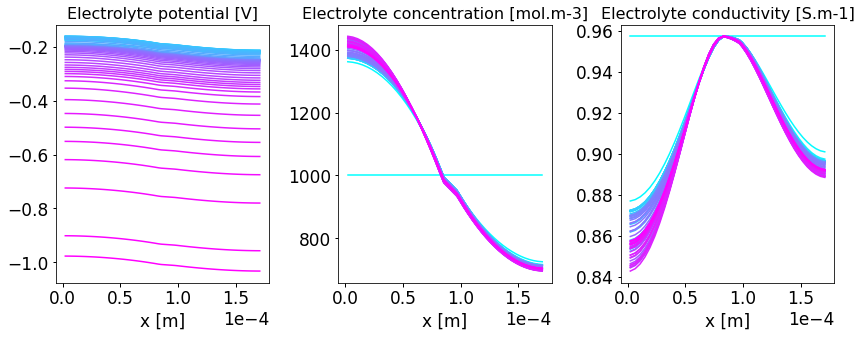

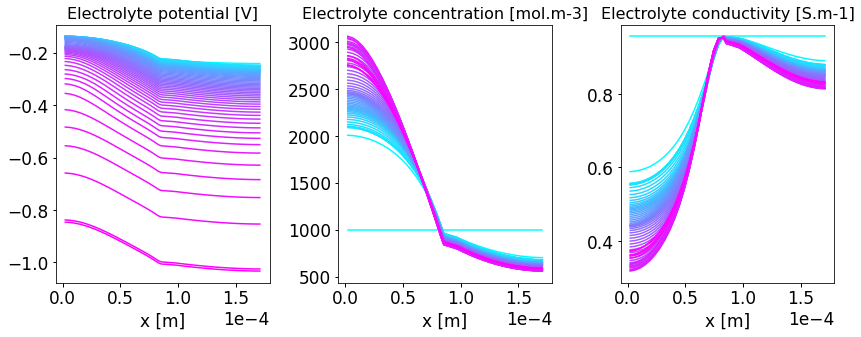

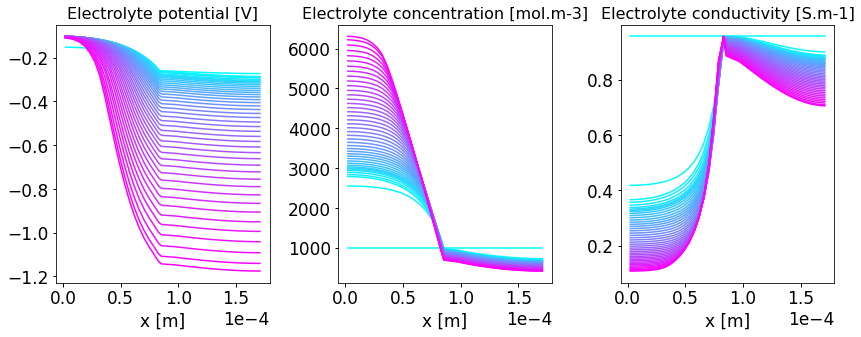

In [32]:
for sol, NegPor in zip(Sol,NegPor_all):
    fig, axs= Plot_Loc_Var_sol(
        sol,
        ["x [m]","x [m]","x [m]",], 
        ["Electrolyte potential [V]",
        "Electrolyte concentration [mol.m-3]",
        "Electrolyte conductivity [S.m-1]",], 
        0,0,'cool',fs)
    """ plt.savefig(
        BasicPath + 
        Target +    "NegPor" +
        f"={NegPor} - cycle={0}, step={0}, Elely potential and cond.png", dpi=200) """


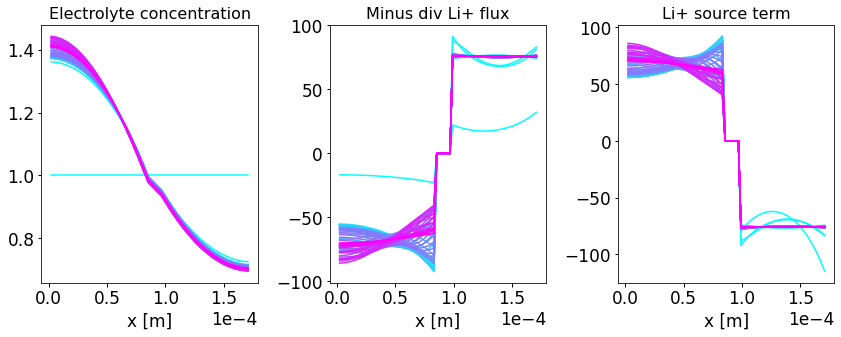

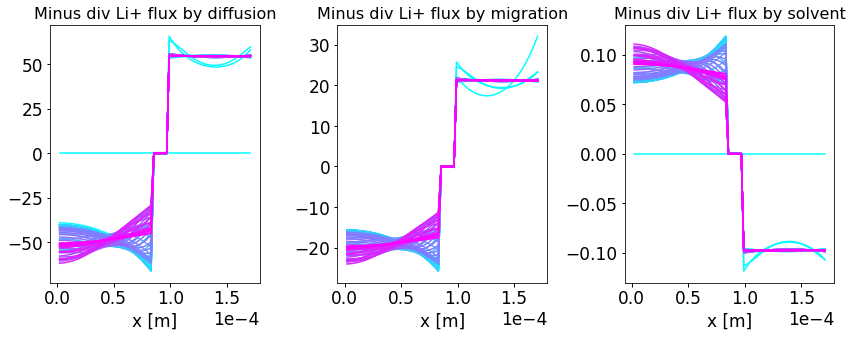

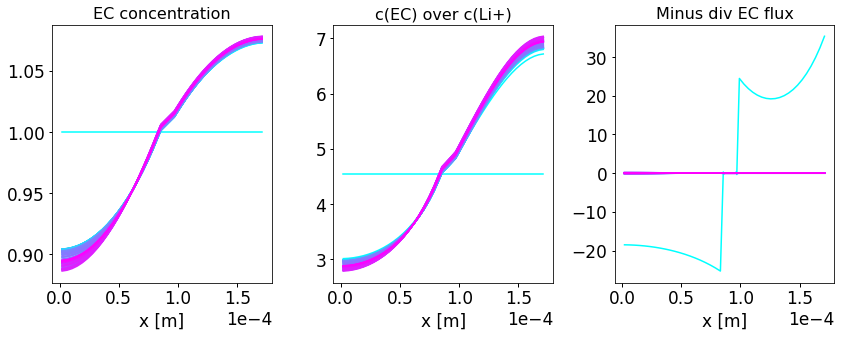

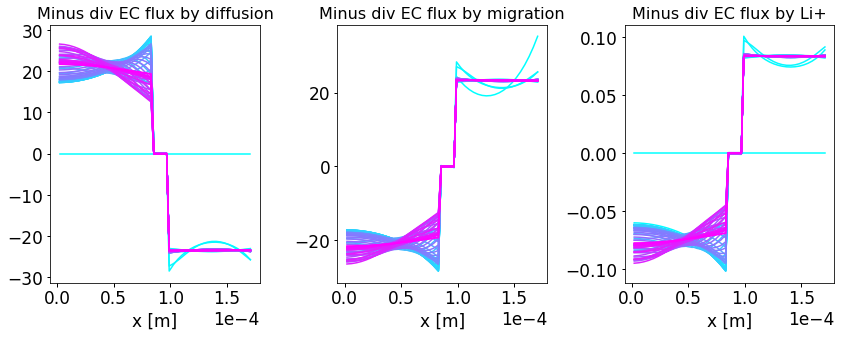

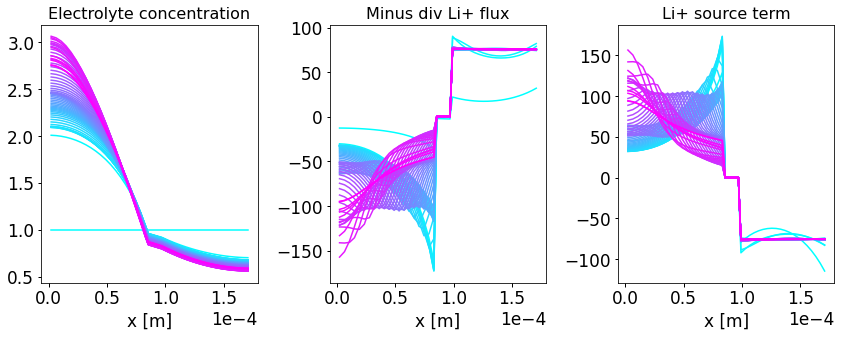

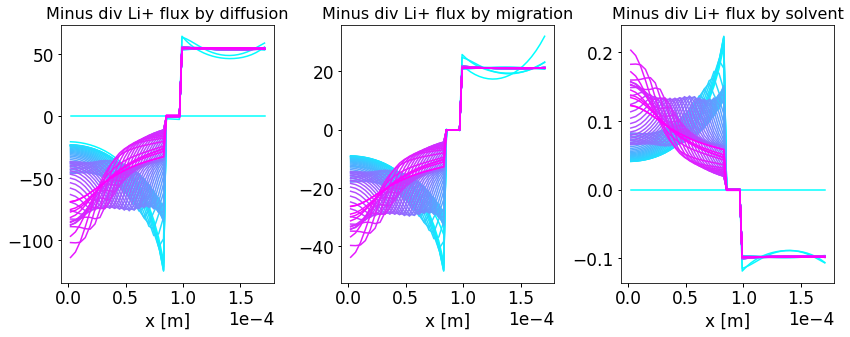

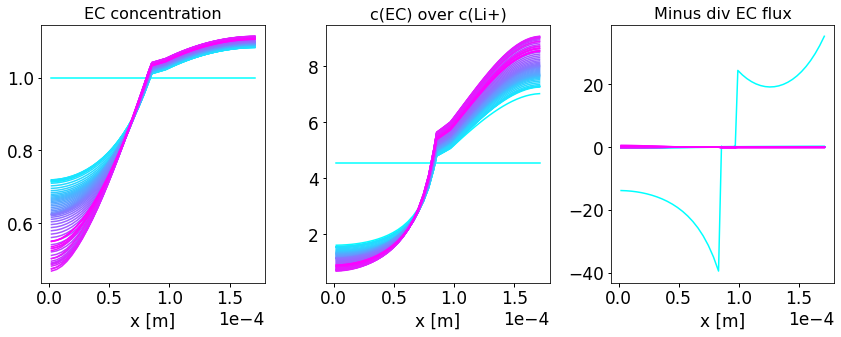

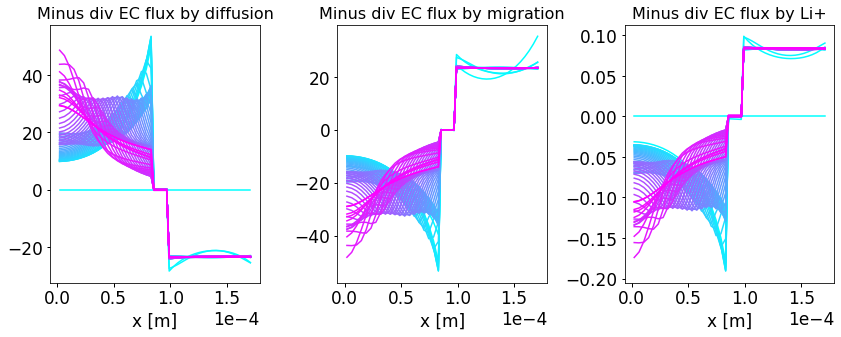

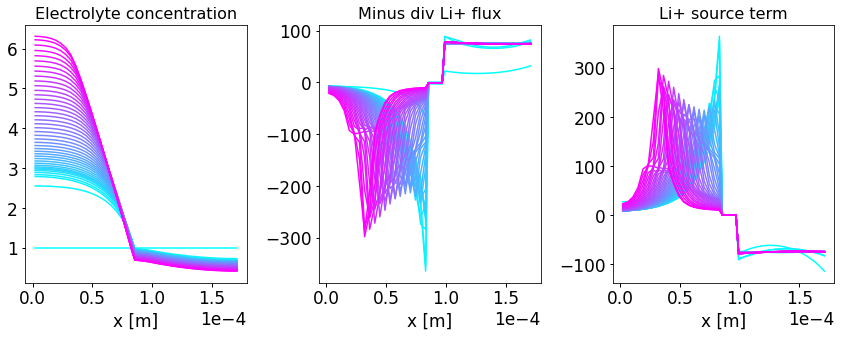

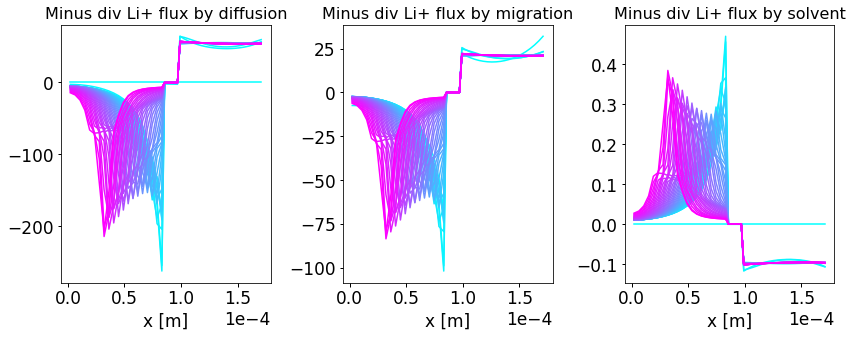

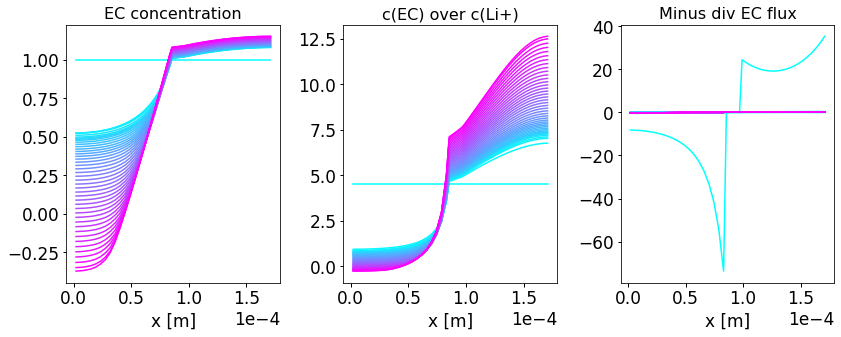

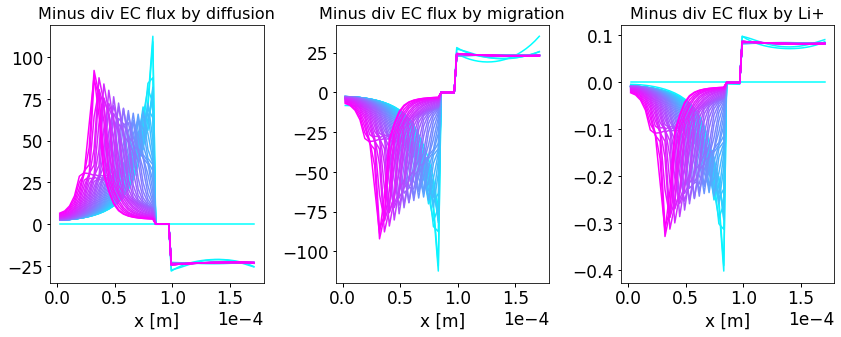

In [33]:
cycle = 0; step_CD = 0;   step_CC = 1; step_CV = 2; 
Plot_Single_Static(
    Sol,"NegPor",cycle, step_CD, 
    NegPor_all,BasicPath , 
    Target,"Tru",'cool',17,200)
